## Example: Single Index Models and Minimum Variance Portfolio Allocation
The computation of the expected returns $\mathbb{E}(r_{i})$ and the covariance matrix $\Sigma$ in the _data-driven_ Minimum-Variance portfolio problem is computationally challenging as the number of assets in the portfolio grows. An alternative is to use index models to compute the expected returns and the covariance. One of the simplest (yet still widely used) index models in the single index models developed by [Sharpe (1963)](https://en.wikipedia.org/wiki/Single-index_model#:~:text=The%20single%2Dindex%20model%20(SIM,used%20in%20the%20finance%20industry.)).

### Single index model
A single index model describes the return of a firm’s stock (or the return of an ETF) in terms of a firm-specific return and the overall market return. Let $R_{i}(t)\equiv\left(r_{i}\left(t\right) - r_{f}\right)$ 
and $R_{m}(t)\equiv\left(r_{m}\left(t\right)-r_{f}\right)$ denote the firm-specific and market **excess returns** (return beyond the risk-free rate), where $r_{f}$ denotes the risk-free rate of return.
Further, let $\epsilon_{i}\left(t\right)$ denote stationary normally distributed random noise process
with mean zero and standard deviation $\sigma_{i}$. Then, the single index model of Sharpe for the excess return of firm (or ETF) $i$ is given by:
$$
\begin{equation*}
R_{i}\left(t\right) = \alpha_{i}+\beta_{i}\cdot{R}_{m}\left(t\right)+\epsilon_{i}
\left(t\right)\qquad{t=1,2,\dots,T}
\end{equation*}
$$
where the $t$ denotes the time index, $\alpha_{i}$ and $\beta_{i}$ are (unknown) model parameters: 
* $\alpha_{i}$ describes the firm-specific return not explained by the market; thus, $\alpha_{i}$ is the idiosyncratic return of firm $i$.
* $\beta_{i}$ has two interpretations. First, it measures the relationship between the excess return of firm $i$ and the excess return of the market. 
A large $\beta_{i}$ suggests that the market returns (or losses) are amplified for firm $i$, while a small $\beta_{i}$ indicates that the market returns (or losses) are damped for firm $i$. 
Second, it represents the relative risk of investing in a firm $i$ relative to the overall market.

### Single index model portfolio allocation problem for risky assets
The risky portfolio allocation problem for a portfolio $\mathcal{P}$ using the single index model is:
\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(R_{i},R_{j}\right) \\
\text{subject to}~\mathbb{E}(R_{\mathcal{P}})& = & \alpha_{\mathcal{P}}+\beta_{\mathcal{P}}\cdot\mathbb{E}(R_{m})\geq{R^{*}} \\
\alpha_{\mathcal{P}} & = & \sum_{i\in\mathcal{P}}\omega_{i}\cdot\alpha_{i}\\
\beta_{\mathcal{P}} & = & \sum_{i\in\mathcal{P}}\omega_{i}\cdot\beta_{i} \\
\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

where the covariance between asset $i$ and asset $j$ is given by:
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}

### Learning objectives
The objective of this worked example is to compute the expected excess return vector $\mathbb{E}(R_{i})$ and the covariance matrix $\mathbf{\Sigma}$ using the single index models (`SIMs`) estimated in the previous module, where we use the [SPDR® S&P 500® ETF Trust](https://www.ssga.com/us/en/intermediary/etfs/capabilities/spdr-core-equity-etfs/spy-sp-500?WT.mc_id=ps_etf-spy_spy-funds_us_google_text_psb_mf2_lp_may24&gad_source=1&gclid=EAIaIQobChMIw-y9tcPThgMVh7BaBR39dw3rEAAYASAAEgJPNfD_BwE&gclsrc=aw.ds) with ticker `SPY` as the market, or benchmark, portfolio. 

* __Prerequisites__: We'll begin by loading the historical dataset consisting of daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Task 1__: Then, we'll compute the expected returns and the covariance arrays from the historical dataset and the single index models we calculated in the previous module.
* __Task 2__: Next, we'll compute the efficient frontier by solving the minimum variance optimization problem for the data-driven and the single index model formulation for a basket of risky assets and compare the efficient frontiers calculated for each approach.
* __Task 3__: Finally, we'll explore the contents of the data-driven and single index minimum-variance portfolios for your collection of risky assets. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the [load(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git).

In [5]:
original_dataset = load(joinpath(_PATH_TO_DATA, "SP500-Daily-OHLC-1-3-2018-to-12-29-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Next, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Let's get a sorted list of firms that we have in cleaned up `dataset`, and save it in the `list_of_all_tickers` array:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

Finally, let's set some constant values, e.g., a value for the `risk_free_rate`:

In [13]:
risk_free_rate = 0.0389; # hypothetical continuous compounded risk free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)

### Compute the covariance and expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 460` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate) # one-trading day Δt

1507×460 Matrix{Float64}:
  0.336088   1.89038     6.98879   …   5.76269     1.75992    2.01562
  2.15097   -0.657039    3.98147       3.96778    -0.750836   2.937
  0.897421  -1.95507    -0.842654      2.86038    -0.394878   2.43031
  6.16272    1.47313    -1.90992       6.56668     5.1095     3.37483
 -3.51528    4.88241    -0.306577      1.77612     3.328     -4.90903
 -0.36462   10.2428      2.76778   …  10.6928      2.20144    2.44313
  3.26779    9.92523     7.33219       5.82065     2.35812    3.11215
 -0.208597   1.24649    -1.55764       2.68177    -1.59373    1.0681
  1.65959   -0.294763    1.91961       0.400949   -0.140935   2.80741
  0.1744     0.0990042  -0.522502     -0.199756   -0.544464  -1.12981
  2.97962   -1.0158      3.82748   …  -0.0867694   2.25035    0.953927
  0.874309  -0.725771    0.961274      0.243296    1.8525     1.44534
  1.06706    0.0580966   1.8466        2.42106     1.36853    1.7907
  ⋮                                ⋱                         
  6.8

Next, estimate the expected excess return for each firm from the `all_firms_excess_return_matrix` using the [mean(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean), which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We save the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(R_{1}),\dotsc,\mathbb{E}(R_{N})$ in the variable `μ`:

In [17]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

Then, estimate the annualized `covariance_matrix` from the `all_firms_return_matrix` using the [cov(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [19]:
Σ = cov(all_firms_excess_return_matrix) |> x-> x*(1/252) # annualized, historical volatility from data

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

Finally, we estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ correlation matrix in the $ρ$ variable:

In [21]:
ρ = cor(all_firms_excess_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

### Load single index models, compute the single index returns and covariance
In a previous module, we estimated the parameters and residual distributions for each `ticker`$\in$`list_of_all_tickers` and saved these to a [JLD2.jl file](https://github.com/JuliaIO/JLD2.jl). Load this file using the [load(...) function](https://juliaio.github.io/JLD2.jl/stable/#save-and-load-functions). 
* Store the model collection in the `sim_model_dictionary` variable, where the keys of the dictionary are the ticker symbols and the values are the parameterized [MySingleIndexModel instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) estimated previously.

In [23]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA, "SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0671224, 0.652999, 0.0389, Normal{Float64}(μ=…
  "EMR"  => MySingleIndexModel(-0.0549877, 1.23526, 0.0389, Normal{Float64}(μ=-…
  "CTAS" => MySingleIndexModel(0.119417, 1.17936, 0.0389, Normal{Float64}(μ=-6.…
  "HSIC" => MySingleIndexModel(-0.0811194, 0.913675, 0.0389, Normal{Float64}(μ=…
  "KIM"  => MySingleIndexModel(-0.0818621, 1.28859, 0.0389, Normal{Float64}(μ=-…
  "PLD"  => MySingleIndexModel(0.0273092, 1.02836, 0.0389, Normal{Float64}(μ=1.…
  "IEX"  => MySingleIndexModel(-0.00940007, 0.963259, 0.0389, Normal{Float64}(μ…
  "BAC"  => MySingleIndexModel(-0.0922207, 1.32778, 0.0389, Normal{Float64}(μ=-…
  "CBOE" => MySingleIndexModel(-0.00982405, 0.588498, 0.0389, Normal{Float64}(μ…
  "EXR"  => MySingleIndexModel(0.0252878, 0.725388, 0.0389, Normal{Float64}(μ=3…
  "NCLH" => MySingleIndexModel(-0.336719, 2.32891, 0.0389, Normal{Float64}(μ=1.…
  "CVS"  => MySingleIndexModel(-0.0703279, 0.78292, 0.0389

Next, pull out the excess return of the `market portfolio` from the excess expected return `μ.` To do this, look up the index for our market portfolio surrogate `SPY,` then get this column of data from the `μ` array. We'll store the expected excess return for `SPY` in the `Rₘ` variable (scalar value):

In [25]:
Rₘ = findfirst(x -> x == "SPY", list_of_all_tickers) |> i -> μ[i]; # this is mean excess return for SPY

#### Compute the expected returns using single index models
Now, compute the expected return for each ticker in the `dataset` using the single index models computed in the previous module using a `for-loop.` For iteration of the loop:
* Get the `ticker` symbol from the `list_of_all_tickers` array, and pull out the corresponding single index model from the `sim_model_dictionary` dictionary. Then, pull out the $(\alpha, \beta)$ parameters from the `sim` model instance and compute the expected return $\mathbb{E}(R_{i})$. Store the expected return in the `μ_sim` array

In [27]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(list_of_all_tickers)
    sim = list_of_all_tickers[i] |> ticker -> sim_model_dictionary[ticker];   
    αᵢ = sim.α
    βᵢ = sim.β
    (αᵢ+βᵢ*Rₘ) |> R̄ᵢ-> push!(μ_sim,R̄ᵢ); # evaluate the SIM for all the models in our collection
end

#### Compute the Covariance matrix using single index models
Next, build the covariance array using single index models. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:
$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$
where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

* To compute the risk $\sigma_{m}$, which is the standard deviation of the return for the market portfolio, we first find the index for `SPY` in the `all_firms_excess_return_matrix` using the [Julia findfirst(..) function](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Any}), and then pass that value to the `all_firms_excess_return_matrix` using the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Finally, we calculate the standard deviation of the return using the [std(...) function exported by the Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics).

In [29]:
σₘ = findfirst(x->x == "SPY", list_of_all_tickers) |> i-> std(all_firms_excess_return_matrix[:, i]); # get SPY σ from data

Finally, we populate the single index covariance array `Σ_sim` using nested [`for-loops.`](https://docs.julialang.org/en/v1/base/base/#for).

In [31]:
Σ_sim = let
    Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
    for i ∈ eachindex(list_of_all_tickers)
        
        outer_ticker = list_of_all_tickers[i]; # ticker on the rows 
        sim_outer = sim_model_dictionary[outer_ticker]; # get SIM model for row ticker
        
        for j ∈ eachindex(list_of_all_tickers)
            
            inner_ticker = list_of_all_tickers[j]; # ticker in the cols
            sim_inner = sim_model_dictionary[inner_ticker]; # get SIM model of the col ticker
            
            if (i == j) # we have a diagonal element
                βᵢ = sim_outer.β
                ϵᵢ = sim_outer.ϵ
                σ_ϵᵢ = params(ϵᵢ)[2];
                Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
            else
                βᵢ = sim_outer.β
                βⱼ = sim_inner.β
                Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
            end
        end
    end
    Σ_sim  = Σ_tmp |> x-> x*(1/252) # annualize
end;

## Task 1: Build the return array and covariance matrix for our low-correlation tickers
Before computing the efficient frontier using data and single index models, we need to determine which stocks to include in the risky portfolio. One approach is to choose stocks with small or negative correlations. Let's delve into this concept by selecting specific stock symbols and then using the methods from earlier modules to calculate their low-correlation partner firms.
* We begin by populating the `correlated_ticker_pairs::Dict{String, Array{Tuple{String, String, Float64},1}}` dictionary. We populate this dictionary using a `for-loop` over the `list_of_all_tickers.` For each ticker:
* We access the ticker at index `i` from the `list_of_all_tickers`. We then access the corresponding row in the correlation matrix `ρ` and then sort using the [Julia sortperm(...) function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm). This function returns the permutation vector that sorts the covariance entries from `smallest` to `largest.` Finally, we generate a list of tickers sorted by correlation in ascending order for each value of `test_ticker` using an [array comprehension operation](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) in combination with the [Julia pipe operation](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We store both the ticker and the entry of the correlation matrix:

In [33]:
correlated_ticker_pair = let
    correlated_ticker_pairs = Dict{String, Array{Tuple{String, String, Float64},1}}();
    for i ∈ eachindex(list_of_all_tickers)
        test_ticker = list_of_all_tickers[i];
        id = sortperm(ρ[i,:])
        [(test_ticker, list_of_all_tickers[id[j]],ρ[i,id[j]]) for j ∈ eachindex(id)] |> tuple -> correlated_ticker_pairs[test_ticker] = tuple;
    end
    correlated_ticker_pairs
end

Dict{String, Vector{Tuple{String, String, Float64}}} with 460 entries:
  "TPR"  => [("TPR", "CPB", -0.0335701), ("TPR", "CLX", -0.0325634), ("TPR", "K…
  "EMR"  => [("EMR", "CLX", 0.0148307), ("EMR", "GLD", 0.0184654), ("EMR", "KR"…
  "CTAS" => [("CTAS", "KR", 0.0051986), ("CTAS", "CLX", 0.0711865), ("CTAS", "G…
  "HSIC" => [("HSIC", "GLD", 0.0203412), ("HSIC", "EA", 0.0574917), ("HSIC", "K…
  "KIM"  => [("KIM", "KR", -0.00164488), ("KIM", "CLX", 0.00152225), ("KIM", "G…
  "PLD"  => [("PLD", "UNG", 0.0825773), ("PLD", "KR", 0.0999649), ("PLD", "IR",…
  "IEX"  => [("IEX", "GLD", 0.0425545), ("IEX", "KR", 0.0930673), ("IEX", "UNG"…
  "BAC"  => [("BAC", "GLD", -0.069935), ("BAC", "CLX", -0.0256813), ("BAC", "KR…
  "CBOE" => [("CBOE", "KR", 0.0110771), ("CBOE", "GLD", 0.0536606), ("CBOE", "U…
  "EXR"  => [("EXR", "KR", 0.0786332), ("EXR", "IR", 0.0901916), ("EXR", "UNG",…
  "NCLH" => [("NCLH", "CLX", -0.091607), ("NCLH", "KR", -0.0647844), ("NCLH", "…
  "CVS"  => [("CVS", "GLD", 0.00256612

Next, specify a collection of tickers that interest you in the `my_list_of_tickers` array, e.g., `AAPL,` `MSFT,` etc. We'll then find the `low-correlation` twin tickers and insert these (along with your initial tickers) into the `my_low_correlation_ticker_array` array:

In [35]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM"];
my_low_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ my_list_of_tickers

  ticker_record_tuple_array = correlated_ticker_pair[base_ticker];
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_low_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = ticker_record_tuple_array[counter+1][2];
        counter += 1;
    end

    push!(my_low_correlation_ticker_array, base_ticker)
    push!(my_low_correlation_ticker_array, twin_ticker)
    
end
my_low_correlation_ticker_array;

Finally, we'll get the indexes of the `low-correlation` tickers that we computed above, i.e., we'll look up the position of the tickers in the `list_of_all_tickers` list and save these values in the `my_list_of_firm_ids` variable by iterating through the `my_low_correlation_ticker_array`:

In [37]:
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_low_correlation_ticker_array
    findfirst(x->x==ticker, list_of_all_tickers) |> i -> push!(my_list_of_firm_ids, i);
end

After selecting the firms for your risky portfolio, calculate the firm-specific expected return vector and covariance matrix. We will store these in the variables $\hat{\mu}_{\star}$ and $\hat{\Sigma}_{\star}$. The single index expected return will have a subscript `sim.`

In [39]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
    push!(μ̂_sim, μ_sim[firm_index])
end
# ---------------------------------------------------------------------- #

In [40]:
μ̂_sim

22-element Vector{Float64}:
  0.21073295027013159
 -0.295131911779009
  0.2071096422442993
  0.042896299418748986
 -0.01998539140920752
 -0.05317247323193198
  0.06993080492212196
 -0.022095680482093715
  0.3862583317931452
 -0.03519266083711634
  0.030778712601516017
  0.03251442137137508
 -0.018242804457282505
 -0.04055780105664847
 -0.07603624633783583
  0.07041003646379124
 -0.10076073302977084
 -0.05786431713273217
 -0.04582213933206383
  0.09578824598042919
 -0.06699217744610869
 -0.07111539025780378

Next, compute the firm-specific covariance $\hat{\Sigma}$ matrix for the data version of the problem:

In [42]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

and then the single index model version of the problem (where the single index version will has a subscript `sim`):

In [44]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your low-correlation collection of stocks
Now, we can compute the data-driven and single index model efficient frontiers, assuming only risky assets. To begin, create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Store this in the `problem_risk` variable. 
* You'll need to pass your covariance array $\hat{\Sigma}_{\star}$, the expected return array $\hat{\mu}_{\star}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Start by setting up the bounds and constants in the problem:

In [46]:
number_of_firms = length(my_list_of_firm_ids);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}) for the `data` version of the problem:

In [48]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂, # data cov matrix
    μ = μ̂, # data expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

and the `single index model` version of the problem (store the single index version of the problem in the `problem_risk_sim` variable):

In [50]:
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂_sim, # sim cov matrix
    μ = μ̂_sim, # sim expected array
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from `0` to `10`$\times{r_{f}}$ and take `number_of_points` steps.  We store these values in the `minimum_desired_reward_array` variable:

In [52]:
minimum_desired_reward_array = range(0.0, stop = 10*risk_free_rate, length = number_of_points) |> collect; # excess return from zero

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop.` For each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem_risk` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier` dictionary.
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [54]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];

    try
        solution = solve(problem_risk)

        # check: did this converge?
        status_flag = solution["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            value = solution["reward"];
            efficient_frontier[key] = value;
        end
    catch err
        # Uncomment to see which R's failed ...
        # println("Failed: desired R = $(problem_risk.R). Infeasible");
    end
end
efficient_frontier;

Let's now do the same thing for the single index model case, where we store the results in the `efficient_frontier_sim` dictionary:

In [56]:
efficient_frontier_sim = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_sim.R = minimum_desired_reward_array[i];

    try
        # compute -
        solution_sim = solve(problem_risk_sim)

        # check: did this converge?
        status_flag = solution_sim["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution_sim["objective_value"]);
            value = solution_sim["reward"];
            efficient_frontier_sim[key] = value;
        end
    catch err
        # Uncomment to see which R's failed ...
        # println("Failed: desired R = $(problem_risk_sim.R). Infeasible");
    end
end
efficient_frontier_sim;

### TODO: Visualize the efficient frontiers for the data and single index model
`Unhide` the code block below to see how we visualized the data-driven and single-index model efficient frontiers using [methods from the Plots.jl package](https://github.com/JuliaPlots/Plots.jl).
* __Summary__: The return distributions predicted by the single-index model and the observed return distributions differ (see the previous module on single-index models to explore these differences). Thus, we expect the data-driven and single-index models to have different efficient frontiers. We observe that the single index model efficient frontier (red curve) is shifted to the left, i.e., the single index model predicts _less risk_ for the same reward. 

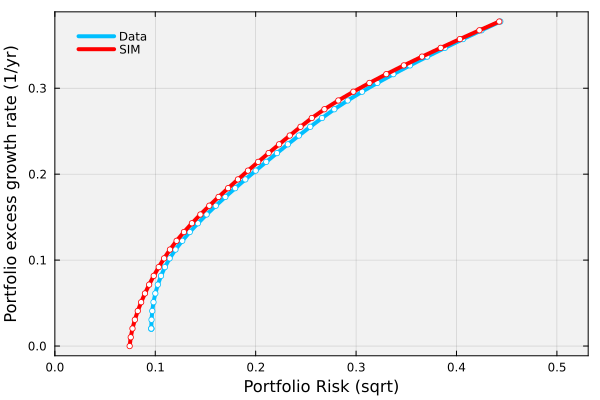

In [58]:
let
    # regular -
    plot(efficient_frontier, lw=4, xlabel="Portfolio Risk (sqrt)", 
        ylabel="Portfolio excess growth rate (1/yr)", fontsize=18, c=:deepskyblue1, 
        xlim=(0.0, 1.2*maximum(efficient_frontier).first), label="Data", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    scatter!(efficient_frontier, label="", c=:white, msc=:deepskyblue1, ms=3)
    
    # single index model -
    plot!(efficient_frontier_sim, lw=4, xlabel="Portfolio Risk (sqrt)", 
        ylabel="Portfolio excess growth rate (1/yr)", fontsize=18, label="SIM", c=:red, 
        xlim=(0.0, 1.2*maximum(efficient_frontier_sim).first))
    scatter!(efficient_frontier_sim, label="", c=:white, msc=:red, ms=3)
end

## Task 3: What's in a data-driven versus single index model portfolio?
The single index model efficient frontier is shifted to the left compared with the data-driven portfolio. Let's explore how this left shift is reflected in the choices of the weights of the assets in the portfolio. To begin, specify a desired portfolio growth rate in the `desired_growth_rate` variable:

In [60]:
desired_growth_rate = 0.25; # select a desired *excess* return where both approaches have data

Next, let's resolve the minimum variance problem for the data-driven and single-index models, assuming a `desired_growth_rate` value. Update the `problem_risk` and `problem_risk_sim` problem instances with the new `R` field:

In [62]:
problem_risk.R = desired_growth_rate;
problem_risk_sim.R = desired_growth_rate;

and solve the minimum-variance allocation problem for both versions of the problem instance:

In [64]:
solution_data = nothing;
solution_sim = nothing;
try
    solution_data = solve(problem_risk);
    solution_sim = solve(problem_risk_sim);
catch err
    # uncoment below to see error message
    # println("What the what? Something happened: $(err)");
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.250507, 3.50207e-9, 0.433733, 1.14023e-6, 1.67439e-8,…
  "reward"          => 0.25
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0572568

`Unhide` the code block below to see how we constructed the portfolio allocation table for the data-driven and single-index model portfolios.
* __Summary__: The data-driven and single-index model allocations are similar, where each non-zero allocation for the data-driven portfolio is preserved in the case of the single-index model. However, several minor differences between the two portfolios do not appear to be correlated with the $\beta$ of the ticker. 

In [101]:
let
    ω_data = solution_data["argmax"];
    ω_sim = solution_sim["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_low_correlation_ticker_array)
        ticker = my_low_correlation_ticker_array[i];
        ω_dataᵢ = ω_data[i];
        ω_simᵢ = ω_sim[i];
        row_data = (
            ticker = ticker,
            β = sim_model_dictionary[ticker].β,
            ω_data = round(ω_dataᵢ, digits=4) |> abs,
            ω_sim = round(ω_simᵢ, digits=4) |> abs,
            Δ_percentage = isapprox(ω_dataᵢ,0.0, atol=1e-2) ? 0.0 : ((ω_simᵢ - ω_dataᵢ)/(ω_dataᵢ))*100
        );
        push!(table_df,row_data)
    end
    table_df
    pretty_table(table_df, tf=tf_simple)
end

========= =========== ========= ========= ===============
  ticker           β    ω_data     ω_sim   Δ_percentage 
  String     Float64   Float64   Float64        Float64 
========= =========== ========= ========= ===============
    AAPL     1.24019    0.2182    0.2505        14.8307
     UNG    0.401587       0.0       0.0            0.0
    MSFT     1.13379    0.4099    0.4337        5.80997
      KR    0.194428     0.005       0.0            0.0
    INTC     1.12753       0.0       0.0            0.0
     CPB    0.227696       0.0       0.0            0.0
      MU     1.52694       0.0       0.0            0.0
     GIS    0.297464       0.0       0.0            0.0
     AMD     1.67809    0.2947    0.2687       -8.82455
     SJM    0.293066       0.0       0.0            0.0
      GS     1.26915       0.0       0.0            0.0
     GLD   0.0822281       0.0       0.0            0.0
     BAC     1.32778       0.0       0.0            0.0
     CLX    0.243847       0.0       0.0  

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.